In [3]:
# IMPORTS
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from math import sqrt


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.callbacks import EarlyStopping


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import date, timedelta, datetime
import pandas_datareader as webreader
import datetime as dt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

ModuleNotFoundError: No module named 'keras.models'

In [1]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    early_stop = EarlyStopping(monitor='loss', patience=50, verbose=1)
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=early_stop)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [3]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []
    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean((np.abs(np.subtract(Y_test, Y_hat)/ Y_test))) * 100
    # Median Absolute Percentage Error (MDAPE)
    mdape = np.median((np.abs(np.subtract(Y_test, Y_hat)/ Y_test)) ) * 100
    return mse, rmse, r, Y_test, Y_hat, mape, mdape

In [4]:
# COMMON
symbol = 'AAPL'
stockname = 'Apple'
timeWindowInYears = 15
timeWindowInDays = timeWindowInYears * 365
testDays = 100
FEATURES = ['Close','High','Low', 'Open', 'Adj Close']

In [5]:
# PULL DATASET FROM YAHOO FINANCIALS
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = pd.Timestamp('today') - timedelta(days=timeWindowInDays)
df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
df.head()

High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2007-02-13  3.046071  3.010714  3.041429  3.025000  580986000.0   2.590229
2007-02-14  3.058571  3.020357  3.022500  3.046429  507981600.0   2.608579
2007-02-15  3.057857  3.027857  3.051429  3.043214  363661200.0   2.605826
2007-02-16  3.050357  3.023571  3.044643  3.029643  399868000.0   2.594205
2007-02-20  3.077143  3.005714  3.023214  3.067857  617702400.0   2.626927

In [6]:
# calculate correlation
df.corr()['Close']

High         0.999894
Low          0.999895
Open         0.999795
Close        1.000000
Volume      -0.502076
Adj Close    0.999830
Name: Close, dtype: float64

In [7]:
# select relevant features
# Extracting the series
dfWithRelevantFeatures = df[FEATURES] # Picking the series with high correlation
print(dfWithRelevantFeatures.tail())

                 Close        High         Low        Open   Adj Close
Date                                                                  
2022-02-02  175.839996  175.880005  173.330002  174.750000  175.616257
2022-02-03  172.899994  176.240005  172.119995  174.479996  172.679993
2022-02-04  172.389999  174.100006  170.679993  171.679993  172.389999
2022-02-07  171.660004  173.949997  170.949997  172.860001  171.660004
2022-02-08  174.830002  175.350006  171.429993  171.729996  174.830002


IndexError: index 5 is out of bounds for axis 0 with size 5

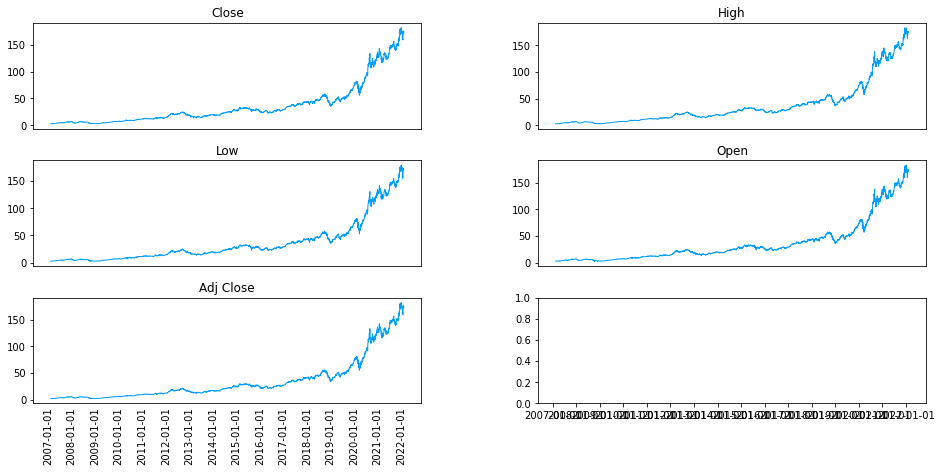

In [8]:
# Plot each column
register_matplotlib_converters()
nrows = 3
ncols = int(round(dfWithRelevantFeatures.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
x = dfWithRelevantFeatures.index
columns = dfWithRelevantFeatures.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
        assetname = columns[f]
        y = dfWithRelevantFeatures[assetname]
        f += 1
        ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i, j].set_title(assetname)
        ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)  

In [9]:
"""
# Train Val Test Split
train_start = dt.date(2010,1,1)
train_end = dt.date(2019,12,31)
train_data = dfWithRelevantFeatures.loc[train_start:train_end]

val_start = dt.date(2020,1,1)
val_end = dt.date(2020,12,31)
val_data = dfWithRelevantFeatures.loc[val_start:val_end]

test_start = dt.date(2021,1,1)
test_end = dt.date(2021,12,31)
test_data = dfWithRelevantFeatures.loc[test_start:test_end]
"""

train_data, remaining_data = np.split(dfWithRelevantFeatures, [int(.85 *len(dfWithRelevantFeatures))])
val_data, test_data = np.split(remaining_data, [int(.5 *len(remaining_data))])
print(train_data.shape,val_data.shape,test_data.shape)

(3208, 5) (283, 5) (284, 5)


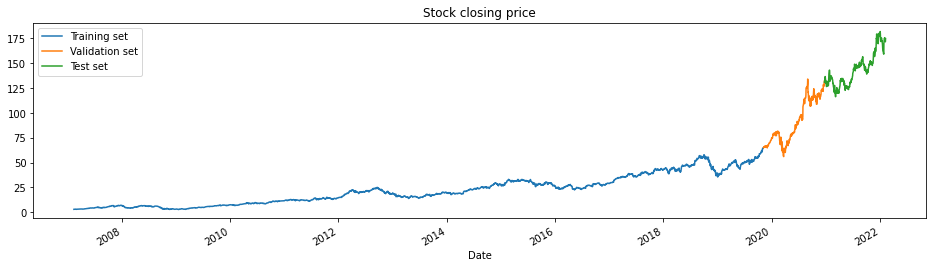

In [10]:
train_data["Close"].plot(figsize=(16,4),legend=True)
val_data["Close"].plot(figsize=(16,4),legend=True)
test_data["Close"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set', 'Validation set', 'Test set'])
plt.title('Stock closing price')
plt.show()


In [11]:
"""
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)
"""

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.fit_transform(val_data)
test = sc.fit_transform(test_data)
print(train.shape,val.shape,test.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(dfWithRelevantFeatures['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3208, 5) (283, 5) (284, 5)


In [12]:
# MODEL TRAINING PARAMS
timesteps = 60
hl = [40,35]
lr = 0.001
batch_size = 32
num_epochs = 140

In [13]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)

Epoch 1/140
99/99 [==============================] - 7s 45ms/step - loss: 0.0076 - val_loss: 0.0269
Epoch 2/140
99/99 [==============================] - 4s 43ms/step - loss: 0.0085 - val_loss: 0.0127
Epoch 3/140
99/99 [==============================] - 4s 42ms/step - loss: 0.0044 - val_loss: 0.0177
Epoch 4/140
99/99 [==============================] - 4s 43ms/step - loss: 0.0064 - val_loss: 0.0116
Epoch 5/140
99/99 [==============================] - 4s 42ms/step - loss: 0.0035 - val_loss: 0.0093
Epoch 6/140
99/99 [==============================] - 4s 43ms/step - loss: 0.0028 - val_loss: 0.0143
Epoch 7/140
99/99 [==============================] - 5s 55ms/step - loss: 0.0014 - val_loss: 0.0113
Epoch 8/140
99/99 [==============================] - 5s 47ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 9/140
99/99 [==============================] - 5s 53ms/step - loss: 0.0012 - val_loss: 0.0106
Epoch 10/140
99/99 [==============================] - 5s 47ms/step - loss: 0.0015 - val_loss: 0.0109

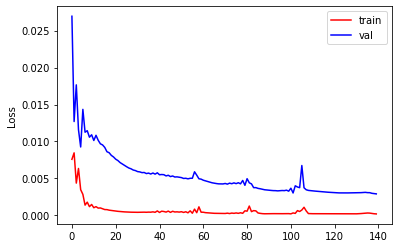

In [14]:
plt.plot(train_error,c = 'r')
plt.plot(val_error,c = 'b')
plt.ylabel('Loss')
plt.legend(['train','val'],loc = 'upper right')
plt.show()

In [15]:
mse, rmse, r2_value,true,predictions,mape,mdape = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(mape, 2)) + ' %')
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(mdape, 2)) + ' %')



MSE = 0.0035024781459294433
RMSE = 0.059181738280735245
R-Squared Score = 0.9430703777366012
Mean Absolute Percentage Error (MAPE): 98.31 %
Median Absolute Percentage Error (MDAPE): 55.02 %


In [16]:
# FIX DATES (X AXIS) and add differences at the bottom of the graph just like in v2
true_unscaled = scaler_pred.inverse_transform(true.reshape(-1, 1))
predictions_unscaled = (scaler_pred.inverse_transform(predictions))
diff = predictions_unscaled - true_unscaled
valid = pd.DataFrame()
valid['Difference'] = diff.flatten()
print(valid)

     Difference
0     -2.078211
1      4.714114
2      3.235761
3      1.052147
4     -0.163977
..          ...
219  -16.256739
220    0.783589
221    6.700628
222    9.903884
223    1.635992

[224 rows x 1 columns]


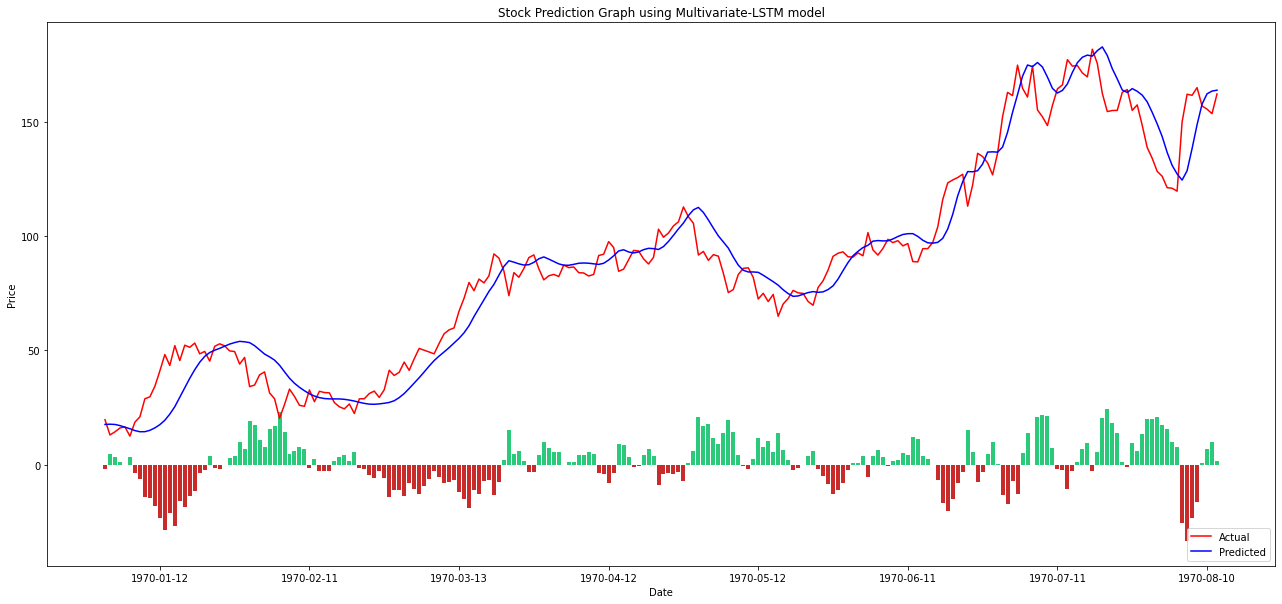

'\ntrain_data_len = len(train_data)\ntest_data_len = len(test_data) - timesteps\n\n# Indexing Batches\ntrain_df = dfWithRelevantFeatures.sort_values(by=[\'Date\']).copy()\n\n# We safe a copy of the dates index, before we need to reset it to numbers\ndate_index = train_df.index\n\n# Get the predicted values\npred_unscaled = scaler_pred.inverse_transform(predictions)\n\n#print(pred_unscaled)\n#print(test_data)\n\n# The date from which on the date is displayed\ndisplay_start_date = pd.Timestamp(2021,1,1)\n\n# Add the date column\ndata_filtered_sub = dfWithRelevantFeatures.copy()\ndata_filtered_sub[\'Date\'] = date_index\n\n# Add the difference between the valid and predicted prices\ntrain = data_filtered_sub[:train_data_len + 1]\nvalid = data_filtered_sub[-test_data_len:]\n\nvalid.insert(1, "Prediction", pred_unscaled.ravel(), True)\nvalid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)\n\n# Zoom in to a closer timeframe\n\nvalid = valid[valid[\'Date\'] > display_start

In [18]:
ind = np.arange(len(valid))
                        
plt.rcParams["figure.figsize"] = (22,10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
plt.plot(true_unscaled,c = 'r')
plt.plot(predictions_unscaled,c = 'b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prediction Graph using Multivariate-LSTM model')
plt.legend(['Actual','Predicted'],loc = 'lower right')

y = valid["Difference"]
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"
plt.bar(ind, y, width=0.8, color=valid['diff_color'])

plt.show()



"""
train_data_len = len(train_data)
test_data_len = len(test_data) - timesteps

# Indexing Batches
train_df = dfWithRelevantFeatures.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(predictions)

#print(pred_unscaled)
#print(test_data)

# The date from which on the date is displayed
display_start_date = pd.Timestamp(2021,1,1)

# Add the date column
data_filtered_sub = dfWithRelevantFeatures.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[-test_data_len:]

valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe

valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()
"""

In [19]:
# Get fresh data until today and create a new dataframe with only the price data
date_start = pd.Timestamp('today') - timedelta(days=200)
new_df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
d = pd.to_datetime(new_df.index)
new_df['Month'] = d.strftime("%m") 
new_df['Year'] = d.strftime("%Y") 
new_df = new_df.filter(FEATURES)

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = sc.transform(last_100_days)

# Create an empty list and Append past 100 days
X_test_new = []
X_test_new.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled)

# Print last price and predicted price for the next day
price_today = round(new_df['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

a = '+'
if percent > 0:
    a = '-'

print('The close price for ' + stockname + ' at ' + str(today) + ' was: ' + str(price_today))
print('The predicted close price is: ' + str(pred_price_unscaled) + ' (' + a + str(percent) + '%)')

The close price for Apple at 2022-02-09 was: 174.83
The predicted close price is: [[165.634]] (-5.26%)
